# Customised advice


In [2]:
#from matplotlib import rcParams
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
#from nilmtk.disaggregate import CombinatorialOptimisation
from datetime import time
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dred = DataSet('data/DRED.h5')

%matplotlib inline

dred.set_window(start="10-18-2015", end="10-19-2015")

data = dred.buildings[1].elec
washing_machine = data['washing machine']


## Plot PV generation and total energy use
The two lists below contain test data of PV generation and total energy use. By plotting the two lists over each other it becomes visible how a lot of the energy is used in periods where there is little or no energy generation.

In [4]:
pv_test_data = [0.0, 0.0, 0.0, 0.0, 0.0, 12.713, 214.371, 737.432, 1410.714, 2039.156, 2452.865, 2729.085, 2792.666, 2673.155, 2365.469, 1821.737, 1121.648, 454.233, 104.846, 0.0, 0.0, 0.0, 0.0, 0.0]

energy_test_data = data.mains().load().next()
energy_test_data = energy_test_data.resample('H').mean()
energy_test_data = energy_test_data.power.apparent.tolist()
#energy_test_data = [0.0, 21.0, 25.0, 523.0, 521.0, 1345.713, 1234.371, 37.432, 510.714, 539.156, 452.865, 729.085, 722.666, 73.155, 65.469, 821.737, 921.648, 1454.233, 1024.846, 1234.0, 876.0, 533.0, 234.0, 4.0]


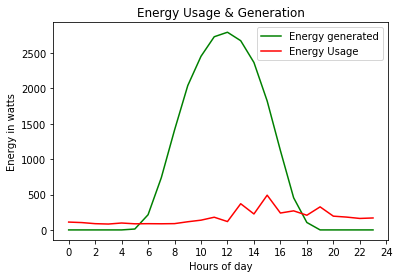

In [5]:
plt.plot(pv_test_data, 'g', label="Energy generated")
plt.plot(energy_test_data, 'r', label="Energy Usage")

yaxis_height= 3000
yaxis_depth = 0
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.legend(loc='upper right')
plt.xlabel("Hours of day")
plt.title('Energy Usage & Generation')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

## Subtracting lists
Below it the two lists are subtracted from each other. By doing this it becomes visible at what times there is a possitive energy output and when there is a negative energy output. Positive meaning more energy being generated than used and negative meaning the opposite.

In [6]:
opportunities = []
for pv, used in zip(pv_test_data, energy_test_data):
    watts = pv - used
    opportunities.append(watts)

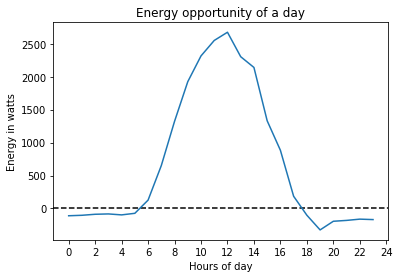

In [7]:
plt.axhline(color='black', linestyle='--')
plt.plot(opportunities)
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.xlabel("Hours of day")
plt.title('Energy opportunity of a day')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

## List of opportunity times
In order to schedule better times for appliance use we'll make a list with desired appliance time ranges. The list will be two dimensional. Each item will contain a start and an end time.

In [8]:
opportunity_found = False
opportunity_times = []
start_time = -1
end_time = -1
for opportunity in opportunities:   
    if opportunity > 0.0 and opportunity_found == False:
        start_time = time(opportunities.index(opportunity))
        opportunity_found = True
    elif opportunity <= 0.0 and opportunity_found == True:
        end_time = time(opportunities.index(opportunity) - 1)
        opportunity_times.append([start_time, end_time])
        opportunity_found = False
        
print(opportunity_times)

[[datetime.time(6, 0), datetime.time(17, 0)]]


## Check if appliance is used in opportunity times
To reschedule first the application has to know if the appliance is used within the opportunity times. We are going to use the washing machine as an example. The graph below depicts the use of the washing machine on one day.

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/nilmtk/utils.py:390: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill(limit=1)
  data = data.resample(**resample_kwargs)


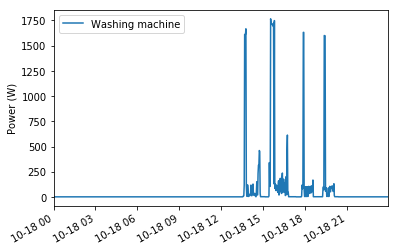

In [9]:
washing_machine.plot()

### Filter and downsample
This data has a sampling size of one second. We only have to detect if the appliance is on. For that reason we first remove all the values that are close to zero because these values indicate that the appliance is idle. Then we downsample the values too one hour. We do this by taking the average of each hour. This changes the unit to watt per hour.

power
                             apparent
2015-10-18 00:00:00+02:00    0.000000
2015-10-18 01:00:00+02:00    0.000000
2015-10-18 02:00:00+02:00    0.000000
2015-10-18 03:00:00+02:00    0.000000
2015-10-18 04:00:00+02:00    0.000000
2015-10-18 05:00:00+02:00    0.000000
2015-10-18 06:00:00+02:00    0.000000
2015-10-18 07:00:00+02:00    0.000000
2015-10-18 08:00:00+02:00    0.000000
2015-10-18 09:00:00+02:00    0.000000
2015-10-18 10:00:00+02:00    0.000000
2015-10-18 11:00:00+02:00    0.000000
2015-10-18 12:00:00+02:00    0.000000
2015-10-18 13:00:00+02:00  218.408026
2015-10-18 14:00:00+02:00   74.011539
2015-10-18 15:00:00+02:00  482.342210
2015-10-18 16:00:00+02:00  105.777963
2015-10-18 17:00:00+02:00  143.145994
2015-10-18 18:00:00+02:00   40.291889
2015-10-18 19:00:00+02:00  173.533683
2015-10-18 20:00:00+02:00    8.859640
2015-10-18 21:00:00+02:00    0.000000
2015-10-18 22:00:00+02:00    0.000000
2015-10-18 23:00:00+02:00    0.000000

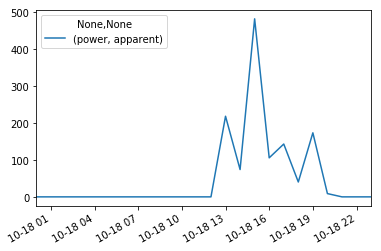

In [10]:
washing_resampled = washing_machine.load().next()
washing_resampled = washing_resampled.replace(0.95, 0.0)
washing_resampled = washing_resampled.resample('H').mean()

washing_resampled.plot()

washing_resampled

The next step is to detect if the appliance is being used outside of opportunity times. 

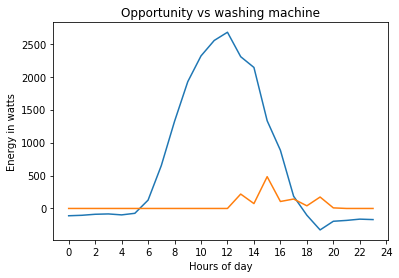

In [11]:
washing_list = washing_resampled.power.apparent.tolist()
plt.plot(opportunities)
plt.plot(washing_list)
tx = np.arange(0, 24, 0.2)
plt.ylabel('Energy in watts')
plt.xlabel("Hours of day")
plt.title('Opportunity vs washing machine')
plt.xticks(np.arange(min(tx), max(tx) + 1, 2))

plt.show()

As shown in the graph above the washingmachine is indeed used outside of opportunity times. To have the code detect this automatically we use the following code.

In [13]:
notification_data = []

for washing_hour_value in washing_list:
    if washing_hour_value > 0:
        washing_hour = time(washing_list.index(washing_hour_value))
        for opportunity_time in opportunity_times:
            if washing_hour > opportunity_time[0] and washing_hour < opportunity_time[1]:
                notification_data.append('Washing machine')